In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import monte_carlo as mc
import black_scholes as bs
import binomial_tree as bt
import payoff as po
import timeit
from scipy.stats import norm

In [ ]:
percentiles = [norm.cdf(x)*100 for x in range(-2,3)]

NameError: name 'norm' is not defined

In [ ]:
def vol_arb(S0,r,K,D,sigmaH,sigmaReal,sigmaImp,T,freq,MC,MC_given):

    dt = T/freq
    freq = int(round(T / dt))
    if MC_given==False: 
        #If MC is not given, MC specifies the drift and number of simulations
        mu,m = MC
        timegrid,stocks = mc.GBM_time_series_fast(S0, mu, sigmaReal, T,dt,m)
        stocks = stocks.T
        time2expiry = 1-timegrid
        time2expiry = np.tile(time2expiry, (m, 1))
    else:
        timegrid,stocks = MC 
        stocks = stocks.T
        m = stocks.shape[0]
        time2expiry = 1-timegrid
        time2expiry = np.tile(time2expiry, (m, 1))
        # Or MC can already be an output of mc.GBM_time_series_fast(S0, mu, sigma, T,dt,m)
        # This can be used to avoide regenerating tracks if (S0, mu, sigma, T,dt,m) are unchanged


    delta0 = bs.delta(S0,K,r,D,sigmaH,1,'call')
    B0 = -bs.bs_formula_price(S0,K,r,D,sigmaImp,T,'call')+delta0*S0
    delta = bs.delta(stocks[:,:-1],K,r,0,sigmaH,time2expiry[:,:-1],'call')
    deltaDiff = np.diff(delta,axis=1)
    cashSteps = deltaDiff*stocks[:,1:-1]
    cashExpWeights =  np.exp(r * dt * (freq - np.arange(1, freq)))
    cashAccFromStock = np.sum(cashSteps*cashExpWeights,axis=1)
    cash_final = cashAccFromStock + B0*np.exp(r*dt*freq)
    payoff_final = po.payoff_call(stocks[:,-1],K)
    stock_final = -delta[:,-1]*stocks[:,-1]
    PL_final = cash_final+payoff_final+stock_final
    if sigmaImp>sigmaReal:
        PL_final = -PL_final #Switch to Short Call-Long stock portfolio
    return np.array([np.percentile(PL_final,p) for p in percentiles])

In [ ]:
S0=100
mu=0.03
r=0.05
K=100
sigmaImp=0.2
sigmaReal= 0.3
m=1000
freq = 252
T=1
D=0
dt = T/freq
MC = mc.GBM_time_series_fast(S0, mu, sigmaReal, T,dt,m)

In [ ]:
sigmaH_range = np.linspace(0.1,0.7,60)
result = []
for sigmaH in  sigmaH_range:
    result.append(vol_arb(S0,r,K,D,sigmaH,sigmaReal,sigmaImp,T,freq,MC,True))
result = np.array(result)

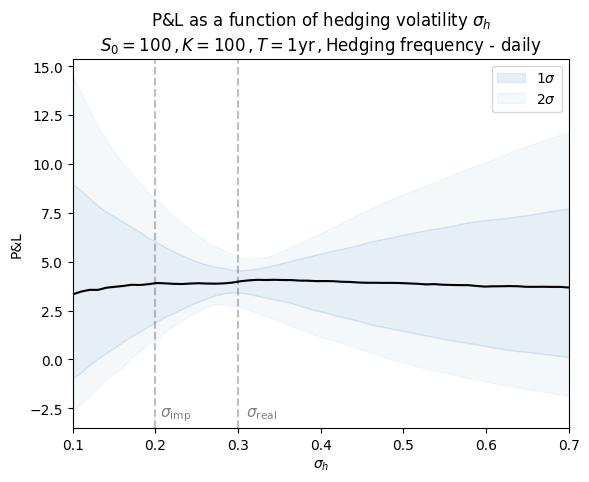

In [ ]:
fig, ax = plt.subplots()

colors= [plt.cm.Blues(0.8), plt.cm.Blues(0.4)]
# ax.plot(sigmaH_range,result[:,0],color=colors[1],alpha=0.00)
# ax.plot(sigmaH_range,result[:,1],color=colors[0],alpha=0.00)
ax.plot(sigmaH_range,result[:,2],color='black')
# ax.plot(sigmaH_range,result[:,3],color=colors[0],alpha=0.00)
# ax.plot(sigmaH_range,result[:,4],color=colors[1],alpha=0.00)

ax.fill_between(sigmaH_range, result[:,1], result[:,2],alpha=0.1, color=colors[0], zorder=0,label=r'1$\sigma$')
ax.fill_between(sigmaH_range, result[:,3], result[:,2],alpha=0.1, color=colors[0], zorder=0)
ax.fill_between(sigmaH_range, result[:,4], result[:,3],alpha=0.1, color=colors[1], zorder=0,label=r'2$\sigma$')
ax.fill_between(sigmaH_range, result[:,0], result[:,1],alpha=0.1, color=colors[1], zorder=0)
plt.axvline(x=sigmaReal, color='k', linestyle='--',alpha=0.25)
plt.axvline(x=sigmaImp, color='k', linestyle='--',alpha=0.25)
plt.legend()

ax.text(
    sigmaReal+0.01, np.min(result[:,0])+0.3,             # position
    r'$\sigma_{\text{real}}$', # text (multi-line ok)
    # transform=ax.transAxes, # axes coords (0–1)
    fontsize=11, ha='left', va='top',
    color='gray'           # optional
)
ax.text(
    sigmaImp+0.005, np.min(result[:,0])+0.3,             # position
    r'$\sigma_{\text{imp}}$', # text (multi-line ok)
    # transform=ax.transAxes, # axes coords (0–1)
    fontsize=11, ha='left', va='top',
    color='gray'           # optional
)
# plt.grid(True)
plt.xlim(0.1,0.7) 
plt.xlabel(r'$\sigma_{h}$')
plt.ylabel('P&L')
plt.title(r'P&L as a function of hedging volatility $\sigma_{h}$'+'\n'+r'$S_0=100\,, K=100\,, T=1\text{yr}\,,\text{Hedging frequency - daily}$')

plt.show()

In [ ]:
freq_range =np.logspace(2,4,20) 
result = []
for f in  freq_range:
    result.append(vol_arb(S0,r,K,D,sigmaReal,sigmaReal,sigmaImp,T,f,[mu,m],False))
result = np.array(result)

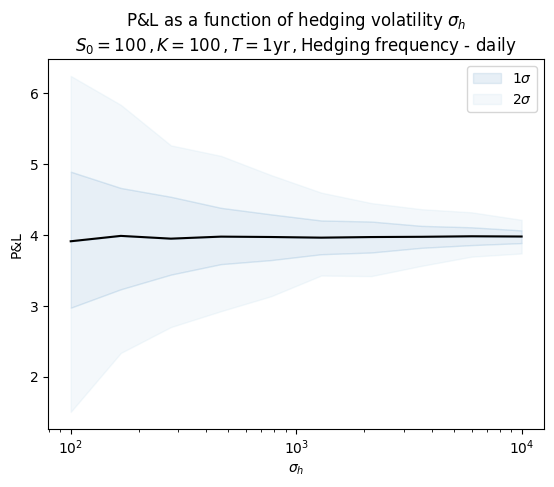

In [9]:
fig, ax = plt.subplots()

colors= [plt.cm.Blues(0.8), plt.cm.Blues(0.4)]

ax.plot(freq_range,result[:,2],color='black')


ax.fill_between(freq_range, result[:,1], result[:,2],alpha=0.1, color=colors[0], zorder=0,label=r'1$\sigma$')
ax.fill_between(freq_range, result[:,3], result[:,2],alpha=0.1, color=colors[0], zorder=0)
ax.fill_between(freq_range, result[:,4], result[:,3],alpha=0.1, color=colors[1], zorder=0,label=r'2$\sigma$')
ax.fill_between(freq_range, result[:,0], result[:,1],alpha=0.1, color=colors[1], zorder=0)
plt.legend()


# plt.grid(True)
# plt.xlim(0.1,0.7) 
plt.xlabel(r'$\sigma_{h}$')
plt.ylabel('P&L')
plt.title(r'P&L as a function of hedging volatility $\sigma_{h}$'+'\n'+r'$S_0=100\,, K=100\,, T=1\text{yr}\,,\text{Hedging frequency - daily}$')
ax.set_xscale("log")
plt.show()